# Feed-Forward Neural Network

This notebook will demonstrate a step-by-step understanding of a Feed-Forward Neural Network (FFNN). In particular, we will be focussing on the implementation of a FFNN in **PyTorch** for classification and regression tasks.

## Intuition (Visual)

<div>
<img src="https://www.deeplearningwizard.com/deep_learning/practical_pytorch/images/logistic_regression_comparison_nn5.png" width="750"/>
</div>

## Intuition (Theoretical)

### Summary

- A feed-forward neural network (FFNN) is an artificial neural network (ANN), wherein connections between the nodes do not form a cycle (but instead move *forward* through the network).
- A FFNN is comprised of:
1. Input Layer
2. Hidden Layers
3. Output Layer
- A FFNN can be shallow/deep, as well as narrow/wide. These properties depend on: 
1. Number of hidden layers
2. Number of hidden units in the layers.

### Input Layer

- The input layer is the initial data being feed through the network.
- Depending on the Python library being used and type of data, this may be 2D or 3D.
- A linear transformation is applied to the input data in the form of $Y = WX + b$, where $W$ are the weights of the neural network and $b$ is the bias of the neural network.

### Hidden Layers

- The hidden layers lie in between the input and output layer.
- Once we apply the linear transformation to the input data, we obtain the form $a_{1} = WX+b$ (where 1 indicates that we are entering the first hidden layer) - $a_{1}$ is known as the pre-activation hidden layer. After, we apply a non-linear activation (this could be sigmoid, tanh etc...) and we obtain $h_{1} = \sigma\left(a_{1}\right)$ - $h_{1}$ is known as the post-activation hidden layer (in the first hidden layer).
- We then repeat this process (applying linear and non-linear activations) till we arrive at the output layer.
- Ths encodes the original data such that the output layer can be interpreted more easily and so that we can learn/capture complex relationships within the data.
- Hidden layers are also known as Fully Connected Layers.

### Output Layer

- Cnce the final hidden layer has been linearly transformed, we enter the output layer (the final layer of the network).  
- A suitable non-linear activation function must be applied here (which will depend on the machine learning task). Popular functions exist such as softmax, crossentropy etc...

<div>
<img src="https://learnopencv.com/wp-content/uploads/2017/10/mlp-diagram.jpg" width="700"/>
</div>

### Extra

- A logistic regression is simply a linear regression ($y = WX+b$), with a non-linear activation applied to it i.e. sigmoid. This means that the logistic regression is simply a 1 layer FFNN.
- If all the non-linear activation functions were the identity function, the FFNN would simply be a special case of linear regression.

## Code

In [1]:
# Imports
from typing import Callable
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

Since we are using ```torch```, try not to mix ```numpy``` into any calculation or dataset conversions. Additionally, check if you have access to ```GPU``` via ```torch.cuda.is_available()```. To use GPU, apply ```torch.device("cuda" if torch.cuda.is_available() else "cpu")```.

### 1. Load Dataset

- For this example we will be looking at famous MNIST dataset (for multiclass classification).
- This dataset is readily available via the *torch* library - in some cases, you may need to load/create the data yourselves.
- If so, it can be useful to store the data similarly to the way that *torch* does it.

In [2]:
# Training set
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
# Test set
test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

### 2. Process Data

- Depending on if you are loading the data or creating the data yourself, you may need to clean the data so that the model can use it. This is perhaps the most trickiest part throughout a Data Science/Machine Learning pipeline.
- In this case, it is good to make *batches* of the dataset so that we can manipulate the way the data is being trained e.g. allow shuffling when training per epoch etc...

In [3]:
# Decide batch size in each portion of the data loader object
batch_size = 128
# Decide the sizes of the datasets
train_size = int(0.8 * len(train_dataset)) 
val_size = len(train_dataset) - train_size 
# Split the dataset
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
# Create DataLoaders for each dataset
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size, 
                                         shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

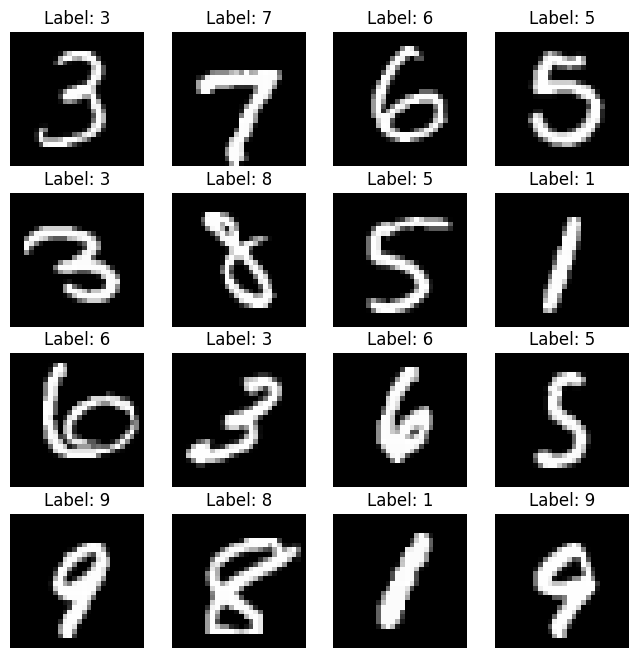

In [4]:
# Visualise data
dataiter = iter(train_loader)
images, labels = next(dataiter)
num_images = 16
# Create plots
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()
for i in range(num_images):
    # Convert to 1-D tensor
    img = images[i].squeeze()
    # Images have 1 channel i.e. greyscale so need to use "gray" mapping
    axs[i].imshow(img, cmap='gray')
    axs[i].title.set_text('Label: ' + str(labels[i].item()))
    axs[i].axis('off')  # Hide axis
plt.show()

Using ```squeeze```, we convert each image in a batch to a 1D tensor of i.e. originally we would have ```[128, 1, 28, 28]```, but after squeeze we have ```[128, 28, 28]```. Note that the $128$ refers to the *batch size*, the $\left[28, 28\right]$ refers to the *image dimension* and the $1$ refers to the tensor structure. Also, if we look at ```len(dataiter)```, we obtain $468$ - this number refers to the number image collections present (where in each collectin, we select a batch of $128$ images from the entire dataset). Hence, the number of total images in the entire MNIST dataset can be calculated as ```(len(iter(train_loader)) + len(iter(test_loader))) x 128```, which gives us $70016$.

### 3. Create Model

- Once the data is ready, we can now look to choose what kind of model we want to create.
- For this notebook, we will implement a FFNN. Other models exist e.g. Convolutional Neural Network (CNN), Recurrent Neural Network (RNN) etc...

In [5]:
# Create FFNN
class FFNN_Long(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        # Allows for multiple inheritance
        super(FFNN_Long, self).__init__()
        # Linear Function (applied to input data) i.e. pre-activation first hidden layer.
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-Linear Function (applied to the pre-activation hidden layer) i.e. post-activation first hidden layer.
        self.relu = nn.ReLU()
        # Linear function (applied to the post-activation hidden layer) i.e. final pre-activation output layer.
        self.fc2 = nn.Linear(hidden_dim, output_dim)  

    def forward(self, x: torch.Tensor):
        # Pre-activation first hidden layer
        out = self.fc1(x)
        # Post-activation first hidden layer
        out = self.relu(out)
        # Final pre-activation output layer
        out = self.fc2(out)
        # Final post-activation output layer (NOTE: This might not be needed if the loss function incorporates the calculation)
        out = nn.LogSoftmax(out, dim = 1)
        return out

Using ```nn.LogSoftmax``` than ```nn.Softmax``` helps improve numerical stability.
We can condense the architecture above by using ```nn.Sequential``` in the ```__init__``` step:

In [6]:
# Create FFNN
class FFNN_Short(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        # Allows for multiple inheritance
        super(FFNN_Short, self).__init__()
        # Create network
        self.net = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                 nn.ReLU(),
                                 nn.Linear(hidden_dim, output_dim))

    def forward(self, x: torch.Tensor):
        # Create network
        out = self.net(x)
        return out

The reason that ```nn.LogSoftmax``` has been removed is because later on, we will be defining our loss as ```nn.CrossEntropyLoss```, which takes into account the ```nn.LogSoftmax``` calculation.

### 4. Instantiate Model Class

- Now the architecture and data are in the correct form, we can being initialise our class.
- Once this is complete, we can begin training.
- We may run into some errors from time to time - this usually occurs because of incompatible dimensions or incorrect data types so be sure to fix these.

In [7]:
# Create arguments
kwargs = {"input_dim": 28*28, 
          "hidden_dim": 100,
          "output_dim": 10}
# Create model
model = FFNN_Short(**kwargs)

### 5. Instantiate Optimiser and Loss Function

- In order to update our weights (to find the optimal ones) and track the model performance, we need to choose an optimiser and loss function.
- The loss function is typically straightforward (as it depends on the machine learning task) however there are a plethora of optimisers you could use e.g. SGD, Adam etc... Usually this is a trial and error choice to find the *best* one.

In [8]:
# Instantiate loss function
loss_fn = nn.CrossEntropyLoss()
# Instantiate optimiser
opt = torch.optim.Adam(params=model.parameters())

It is important to recognise that ```model.parameters()``` are the parameters that we wish to update/optimise. If these are not correctly defined in the ```__init__```, then the network may not be fully functional.

### 6. Model Training

- We are now ready to train the model.
- Through training, it is also useful to record some metrics to see how the model is performing.
- We use the loss of model to dictate potential *early stopping* of the model (although we could use other measures as well) i.e. if the model loss starts increasing after it has decreased, we are potentially overfitting and so should stop training and keep the model at that instance. This can be applied per ```epoch``` or at some multiple of ```n_iters```.
- When evaluating the model, it is necessary to apply ```model.eval()``` along with ```torch.no_grad()``` and once this is complete, to apply ```model.train()``` after if the model architecture includes layers of ```dropout```, ```batch_normalisation``` etc...
- The training and evaluation phase below is a generalised architecture; there are other variations of this which you may want to experiment with!

In [9]:
# Calculate number of epochs
n_iters = 15000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

In [10]:
# Initialize the early stopping parameters
best_val_loss = float('inf') 
patience = 3
epochs_no_improve = 0
early_stop = False

In [11]:
# Train model
for epoch in range(num_epochs):
    # Iterate through entire collection (per batch)
    for images, labels in train_loader:
        # Clear gradients with respect to parameters
        opt.zero_grad()
        # Forward pass
        outputs = model(images.view(images.shape[0], -1))
        # Calculate loss
        loss = loss_fn(outputs, labels)
        # Backward pass
        loss.backward()
        # Parameter update
        opt.step()
    # Evaluate model (NOTE: In the evaluation phase, the model parameters do not need updating!)
    with torch.no_grad():
        # Initialise validation loss 
        val_loss = 0
        # Initialise secondary metric
        correct = 0
        # Iterate through entire collection (per batch)
        for images, labels in val_loader: 
            # Forward pass
            outputs = model(images.view(images.shape[0], -1))
            # Obtain predictons
            _, preds = torch.max(outputs.data, dim=1)
            # Total correct predictions
            correct += (preds == labels).sum()
            # Calculate loss
            loss = loss_fn(outputs, labels)
            # Accumulate loss
            val_loss += loss.item()
        # Record secondary metric
        val_acc_score = 100 * correct / len(val_loader.dataset)
        # Print loss and accuracy
        print(f"Epoch: {epoch} | Validation loss: {val_loss} | Validation accuracy: {val_acc_score}")
        # If the validation loss is at a new minimum, save the model
        if val_loss < best_val_loss:
            torch.save(model.state_dict(), 'best_model.pth')
            best_val_loss = val_loss
            epochs_no_improve = 0
        # If the validation loss is not improving for certain patience, stop training!
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                early_stop = True
                break

Epoch: 0 | Validation loss: 26.496377483010292 | Validation accuracy: 91.90833282470703
Epoch: 1 | Validation loss: 21.044753916561604 | Validation accuracy: 93.66666412353516
Epoch: 2 | Validation loss: 16.878490149974823 | Validation accuracy: 94.7249984741211
Epoch: 3 | Validation loss: 14.308648258447647 | Validation accuracy: 95.57499694824219
Epoch: 4 | Validation loss: 12.77071376889944 | Validation accuracy: 95.91666412353516
Epoch: 5 | Validation loss: 11.573565408587456 | Validation accuracy: 96.4000015258789
Epoch: 6 | Validation loss: 10.647579707205296 | Validation accuracy: 96.57499694824219
Epoch: 7 | Validation loss: 10.278008960187435 | Validation accuracy: 96.86666870117188
Epoch: 8 | Validation loss: 9.594898546114564 | Validation accuracy: 97.04166412353516
Epoch: 9 | Validation loss: 9.033723533153534 | Validation accuracy: 97.15833282470703
Epoch: 10 | Validation loss: 9.220696290954947 | Validation accuracy: 97.07499694824219
Epoch: 11 | Validation loss: 8.956208

If the validation loss is displaying ```inf```, then something has gone wrong with the data or the model - debug the code to check which! 

In [12]:
# Load saved model
model.load_state_dict(torch.load('best_model.pth')) 

<All keys matched successfully>

### 7. Model Testing

- Now that the model has been trained and evaluated, we can test the optimal model on unseen data.
- This is a crucial part as it shows whether or not the model is generalisable i.e. has low variance.

In [13]:
# Test model
correct = 0
for images, labels in test_loader: 
    # Forward pass
    outputs = model(images.view(images.shape[0], -1))
    # Obtain predictons
    _, preds = torch.max(outputs.data, dim=1)
    # Total correct predictions
    correct += (preds == labels).sum()
# Record secondary metric
test_acc_score = 100 * correct / len(test_dataset)
print(f"Test accuracy: {test_acc_score}")

Test accuracy: 97.75


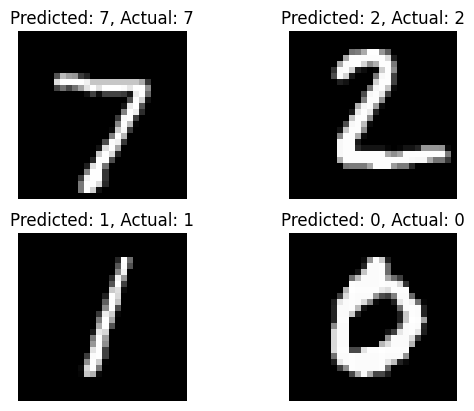

In [14]:
# Visualise predictions
images, labels = next(iter(test_loader))
# Predict labels for the test images
with torch.no_grad():
    outputs = model(images.view(images.shape[0], -1))
    _, predicted = torch.max(outputs, 1)  
# Plot the images with their predicted labels
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i].view(28, 28), cmap='gray') 
    plt.title(f"Predicted: {predicted[i]}, Actual: {labels[i]}")
    plt.axis('off')
plt.show()

Note that using accuracy may not be the best metric to use to quantify the model performance - there are other metrics we can use e.g. F-1, Precision etc... Additionally, it may be convenient to ```flatten``` the arrays within the dataset so that we do not have to do ```images.view(images.shape[0], -1)``` (which may require some data manipulation before storing it as a ```DataLoader```).

## Final Remarks

Thank you for reading this notebook. Note that there are other implementations of feed-forward neural networks (which I would advise you to take a look at to see any differences of similarities with this version).
If there are any mistakes or things that need more clarity, feel free to respond and I will be happy to reply 😊.

© *PolyNath 2023*